# Application for the More Electric Aircraft (MEA) conference

This document has been published for reproducing the application presented in the 2024 [More Electric Aircraft Conference](https://conference-mea.org/). The code and results are given in the following.

The objective is to estimate the impact of electric, hybrid-electric and hydrogen aircraft on aviation CO<sub>2</sub> emissions and energy consumption. It is the first application which includes the use of electric and hybrid-electric architectures in the AeroMAPS fleet model.

> **⚠ This notebook has been developed with the AeroMAPS version v0.6.1-beta for obtaining the paper results. However, this notebook has been or could be modified in order to be executable with the latest versions of AeroMAPS, which sometimes leads to different results compared to the ones from the paper, due to some models' modifications. In order to retrieve the results of the paper, one can use the v0.6.1-beta version associated with the original notebook.**

## Load and process

In [1]:
%matplotlib widget
import time
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_bottom_up,
    models_energy_without_fuel_effect,
    models_offset,
    models_climate_simple_gwpstar,
    models_sustainability,
)
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
    SubCategory,
    SubcategoryParameters,
)

In [2]:
models = {
    "models_traffic": models_traffic,
    "models_efficiency_bottom_up": models_efficiency_bottom_up,
    "models_energy_without_fuel_effect": models_energy_without_fuel_effect,
    "models_offset": models_offset,
    "models_climate_simple_gwpstar": models_climate_simple_gwpstar,
    "models_sustainability": models_sustainability,
}

In [3]:
process = create_process(
    models=models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

In [4]:
# Change end year
process.parameters.end_year = 2060
process.setup(add_examples_aircraft_and_subcategory=False)

## Scenario settings

In [5]:
# Paper settings

## Scenario settings
## For all the scenarios, except for the mix scenario (4), you have to specify manually:
## the aircraft characteristics (market share, performance, EIS...) and the type of fuel used (ELECTRIC, HYBRID_ELECTRIC, HYDROGEN)
## For HYBRID_ELECTRIC architectures, you have to add an "hybridization_factor"
## Here, for the scenarios "Others", the default settings correspond to scenario (3) for the reference values
## Note that NOx, soot, DOC and cruise altitute are not considered here (random values)
SCENARIO = "Mix"  # Choose between "Others" and "Mix"

## Settings for sensitivity analyses
DROP_IN_FUEL = "Kerosene"  # Choose between "Kerosene" and "ReFuelEU"
ELECTRICITY = (
    "Dedicated"  # Choose between "Dedicated", "Linear transition" and "Accelerated transition"
)

In [6]:
# Aircraft fleet for the other scenarios

if SCENARIO == "Others":

    ## Initialization
    fleet = process.fleet

    ## Subcategories (excluding long range which is not impacted by the studied architectures)
    total_value = 33  # Share of the ASK that can be covered by the studied architecture
    if total_value <= 25:  # 25% of the world ASK is short range (below 1500 km)
        total_value_short = total_value / 25 * 100
        total_value_medium = 0
    if (
        total_value > 25 and total_value < 25 + 35
    ):  # 35% of the world ASK is medium range (between 1500 km and 4000 km)
        total_value_short = 100
        total_value_medium = (total_value - 25) / 35 * 100
    fleet.categories["Short Range"].subcategories[0].parameters.share = 100 - total_value_short
    sr_subcat = SubCategory("SR - New", parameters=SubcategoryParameters(share=total_value_short))
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    fleet.categories["Medium Range"].subcategories[0].parameters.share = 100 - total_value_medium
    mr_subcat = SubCategory("MR - New", parameters=SubcategoryParameters(share=total_value_medium))
    fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)

    ## Basic Short Range
    short_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=-75.0,
        soot_evolution=-100.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft = Aircraft(
        "New Short-range Aircraft - Conventional",
        parameters=short_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

    ## New Short Range
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - New",
        parameters=short_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)

    ## Basic Medium Range
    medium_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft = Aircraft(
        "New Medium-range Aircraft",
        parameters=medium_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

    ## New Medium Range
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - New",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Medium Range"].subcategories[1].add_aircraft(
        aircraft=medium_range_aircraft_new
    )

    ## Basic Long Range
    long_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.0,
    )
    long_range_aircraft = Aircraft(
        "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)

    ## Fleet renewal
    fleet.categories["Short Range"].parameters.life = 20
    fleet.categories["Medium Range"].parameters.life = 20
    fleet.categories["Long Range"].parameters.life = 20

In [7]:
# Aircraft fleet for mix scenario

if SCENARIO == "Mix":

    ## Initialization
    fleet = process.fleet

    ## Subcategories (excluding long range which is not impacted by the studied architectures)
    total_value = 47  # Share of the ASK that can be covered by the studied architecture
    if total_value <= 25:
        total_value_short = (
            total_value / 25 * 100
        )  # 25% of the world ASK is short range (below 1500 km)
        total_value_medium = 0
    if (
        total_value > 25 and total_value < 25 + 35
    ):  # 35% of the world ASK is medium range (between 1500 km and 4000 km)
        total_value_short = 100
        total_value_medium = (total_value - 25) / 35 * 100

    ## Distribution between the architectures: the order of priority, based on emissions reduction, is electric aircraft, hydrogen aircraft and hybrid-electric aircraft
    share_elec = 7 / 25 * 100
    share_hydrogen_sr = (25 - 7) / 25 * 100
    share_hydrogen_mr = (33 - 25) / 25 * 100
    fleet.categories["Short Range"].subcategories[0].parameters.share = 0
    sr_subcat = SubCategory("SR - Electric", parameters=SubcategoryParameters(share=share_elec))
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    sr_subcat = SubCategory(
        "SR - Hydrogen/HE", parameters=SubcategoryParameters(share=share_hydrogen_sr)
    )
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    fleet.categories["Medium Range"].subcategories[0].parameters.share = 100 - share_hydrogen_mr
    mr_subcat = SubCategory(
        "MR - Hydrogen/HE", parameters=SubcategoryParameters(share=share_hydrogen_mr)
    )
    fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)

    ## Basic Short Range
    short_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=-75.0,
        soot_evolution=-100.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft = Aircraft(
        "New Short-range Aircraft - Conventional",
        parameters=short_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

    ## New Short Range - Electric
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2040,
        consumption_evolution=50.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Electric",
        parameters=short_range_aircraft_new_params,
        energy_type="ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)

    ## New Short Range - Hybrid-electric
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Hybrid-electric",
        parameters=short_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[2].add_aircraft(aircraft=short_range_aircraft_new)

    ## New Short Range - Hydrogen
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=5.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Hydrogen",
        parameters=short_range_aircraft_new_params,
        energy_type="HYDROGEN",
    )
    fleet.categories["Short Range"].subcategories[2].add_aircraft(aircraft=short_range_aircraft_new)

    ## Basic Medium Range
    medium_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft = Aircraft(
        "New Medium-range Aircraft",
        parameters=medium_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

    ## New Medium Range - Hybrid-electric
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - Hybrid-electric",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Medium Range"].subcategories[1].add_aircraft(
        aircraft=medium_range_aircraft_new
    )

    ## New Medium Range - Hydrogen
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=5.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - Hydrogen",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYDROGEN",
    )
    fleet.categories["Medium Range"].subcategories[1].add_aircraft(
        aircraft=medium_range_aircraft_new
    )

    ## Basic Long Range
    long_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.0,
    )
    long_range_aircraft = Aircraft(
        "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)

    ## Fleet renewal
    fleet.categories["Short Range"].parameters.life = 20
    fleet.categories["Medium Range"].parameters.life = 20
    fleet.categories["Long Range"].parameters.life = 20

C:\Users\a.salgas.ISAE-SUPAERO\PycharmProjects\AeroMAPS\aeromaps\models\air_transport\aircraft_fleet_and_operations\fleet\fleet_model.py:920: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (
C:\Users\a.salgas.ISAE-SUPAERO\PycharmProjects\AeroMAPS\aeromaps\models\air_transport\aircraft_fleet_and_operations\fleet\fleet_model.py:920: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (


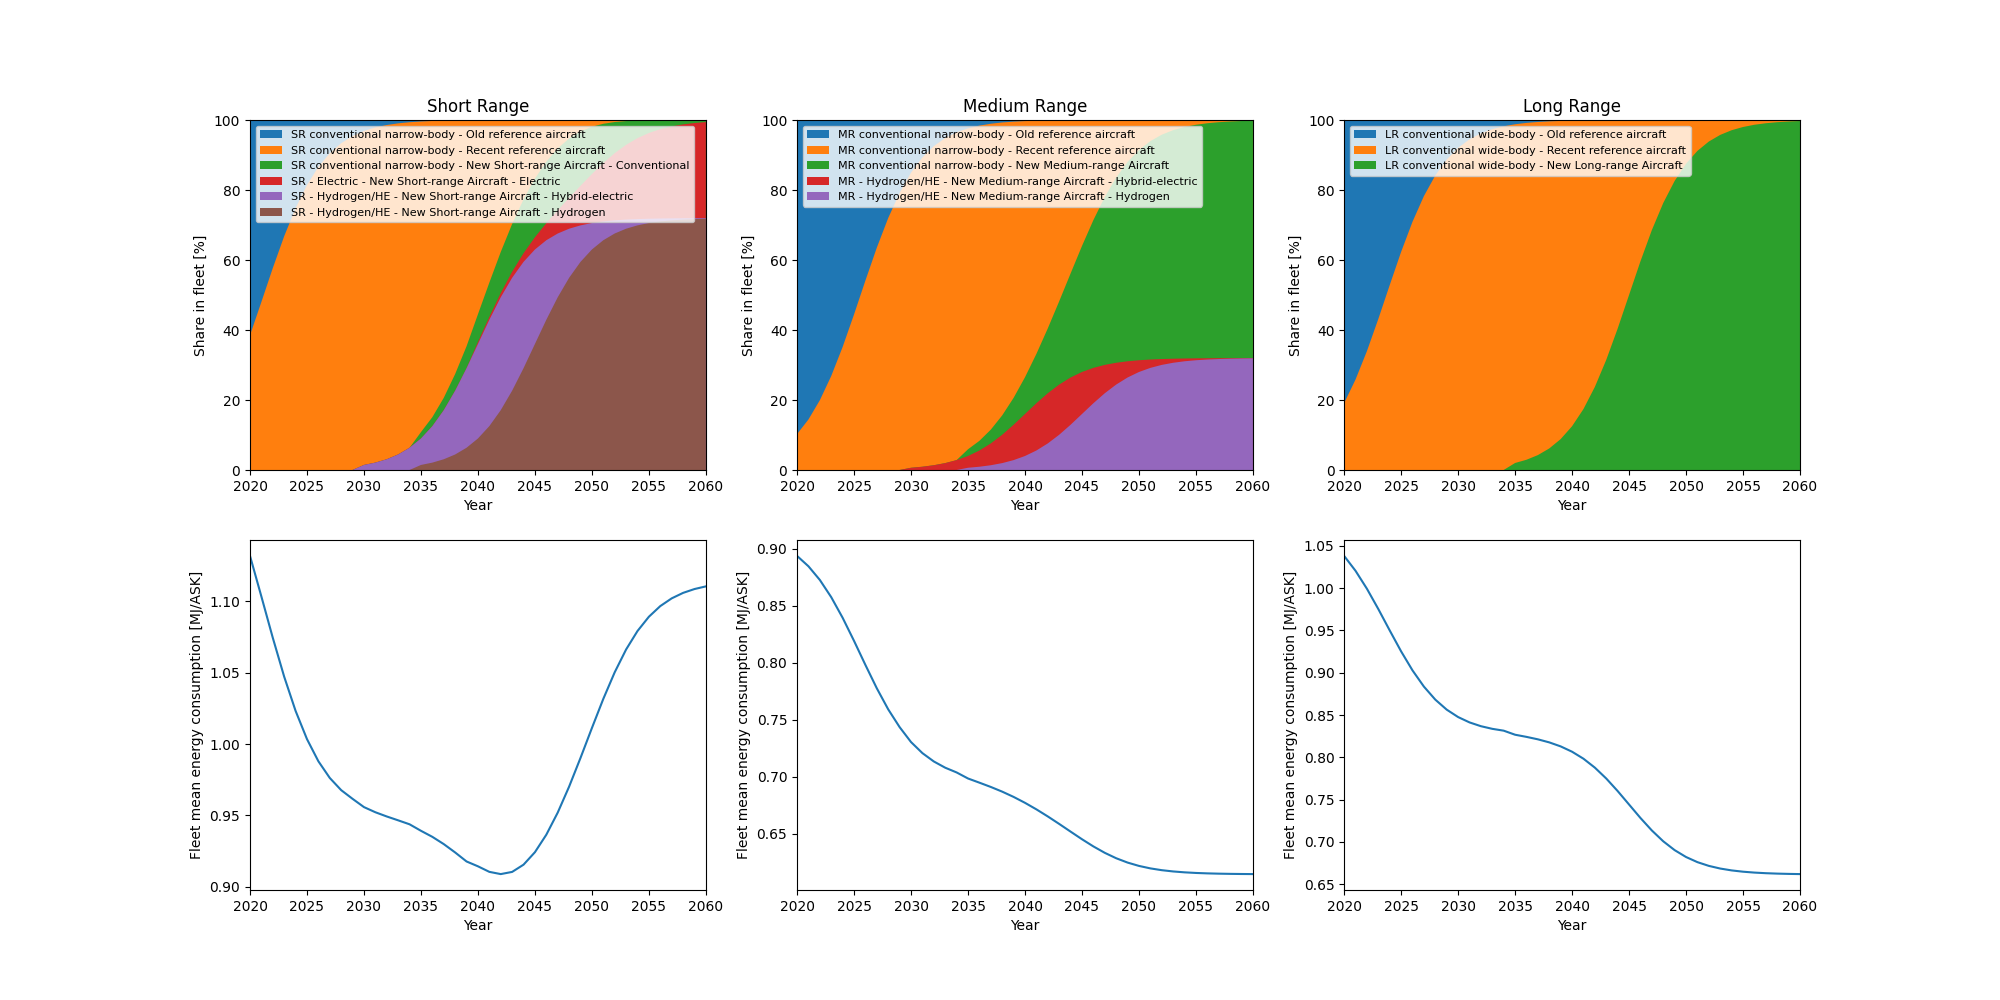

In [8]:
fleet_model = process.fleet_model
fleet_model.compute()
fleet_model.plot()

In [9]:
# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
if DROP_IN_FUEL == "Kerosene":
    process.parameters.biofuel_share_reference_years = []
    process.parameters.biofuel_share_reference_years_values = [0.0]
    process.parameters.electrofuel_share_reference_years = []
    process.parameters.electrofuel_share_reference_years_values = [0.0]
elif DROP_IN_FUEL == "ReFuelEU":
    process.parameters.biofuel_share_reference_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.biofuel_share_reference_years_values = [0.0, 4.8, 24.0, 35.0, 40.0]
    process.parameters.electrofuel_share_reference_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.electrofuel_share_reference_years_values = [0.0, 1.2, 10.0, 35.0, 60.0]

In [10]:
# Various environmental settings

## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
## Assumption of a current use of HEFA FOG and an equal distribution from 2030 according to biomass resources distribution
process.parameters.biofuel_hefa_fog_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_hefa_fog_share_reference_years_values = [100, 0.7, 0.7]
process.parameters.biofuel_hefa_others_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_hefa_others_share_reference_years_values = [0.0, 3.8, 3.8]
process.parameters.biofuel_ft_others_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_ft_others_share_reference_years_values = [0.0, 76.3, 76.3]
process.parameters.biofuel_ft_msw_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_ft_msw_share_reference_years_values = [0.0, 7.4, 7.4]

## Emission factors for electricity (2019 value: 429 gCO2/kWh)
if ELECTRICITY == "Dedicated":
    process.parameters.electricity_emission_factor_reference_years = []
    process.parameters.electricity_emission_factor_reference_years_values = [10.0]
elif ELECTRICITY == "Linear transition":
    process.parameters.electricity_emission_factor_reference_years = [2020, 2060]
    process.parameters.electricity_emission_factor_reference_years_values = [429.0, 10.0]
elif ELECTRICITY == "Accelerated transition":  # Division by 2.5 per decade
    process.parameters.electricity_emission_factor_reference_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.electricity_emission_factor_reference_years_values = [
        429.0,
        170.0,
        70.0,
        25.0,
        10.0,
    ]

## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
## Assumption of a dedicated use of electrolysis pathway here
process.parameters.hydrogen_electrolysis_share_reference_years = []
process.parameters.hydrogen_electrolysis_share_reference_years_values = [100]
process.parameters.hydrogen_gas_ccs_share_reference_years = []
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0]
process.parameters.hydrogen_coal_ccs_share_reference_years = []
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0]
process.parameters.hydrogen_gas_share_reference_years = []
process.parameters.hydrogen_gas_share_reference_years_values = [0]

In [11]:
# Other settings

## Air traffic evolution - Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [3.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [3.0]

## Aircraft fleet and operation evolution - Aircraft load factor
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

# Aircraft fleet and operation evolution - Operations
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## Compute

In [12]:
process.compute()

C:\Users\a.salgas.ISAE-SUPAERO\PycharmProjects\AeroMAPS\aeromaps\models\air_transport\aircraft_fleet_and_operations\fleet\fleet_model.py:920: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (
C:\Users\a.salgas.ISAE-SUPAERO\PycharmProjects\AeroMAPS\aeromaps\models\air_transport\aircraft_fleet_and_operations\fleet\fleet_model.py:920: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (


## Results

The following results are those obtained for the scenario set previously.

In [13]:
print(
    "CO2 emissions in 2050:",
    round(process.data["climate_outputs"]["co2_emissions"][2050], 0),
    "MtCO2",
)
print(
    "Cumulative CO2 emissions between 2020 and 2050:",
    round(process.data["vector_outputs"]["cumulative_co2_emissions"][2050], 1),
    "GtCO2",
)
print(
    "Energy consumption in 2050:",
    round(process.data["vector_outputs"]["energy_consumption"][2050] / 10**12, 1),
    "EJ",
)
print(
    "CO2 emissions in 2060:",
    round(process.data["climate_outputs"]["co2_emissions"][2060], 0),
    "MtCO2",
)

CO2 emissions in 2050: 952.0 MtCO2
Cumulative CO2 emissions between 2020 and 2050: 31.6 GtCO2
Energy consumption in 2050: 17.3 EJ
CO2 emissions in 2060: 1121.0 MtCO2


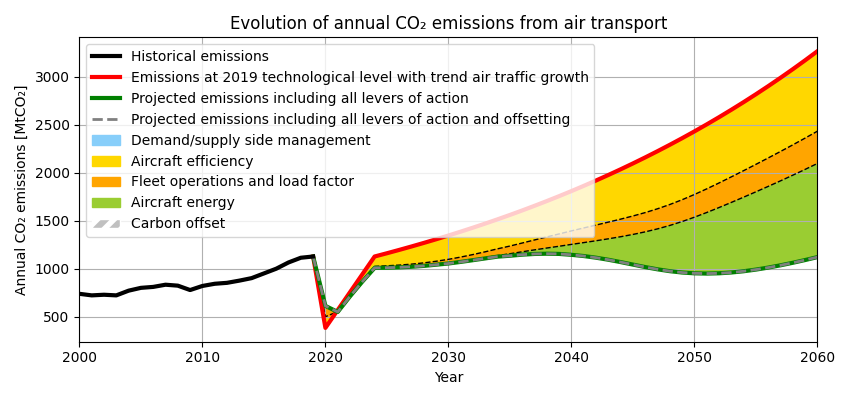

In [14]:
process.plot("air_transport_co2_emissions")

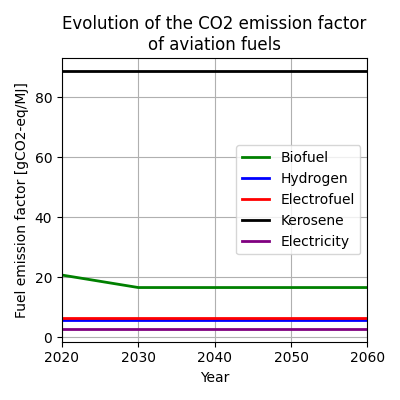

In [15]:
process.plot("emission_factor_per_fuel")

# All results

This part includes the main plots of the paper, summarizing the different scenarios and sensitivity analyses. The scenarios data have been stored on csv files.

## Baseline scenarios

In [16]:
mea_data_df = read_csv("data/mea_data.csv", delimiter=";")
mea_data = mea_data_df.values
mea_data_reference = mea_data[:, 1]
mea_data_electric = mea_data[:, 2]
mea_data_electric_low = mea_data[:, 3]
mea_data_electric_high = mea_data[:, 4]
mea_data_hybridelectric = mea_data[:, 5]
mea_data_hybridelectric_low = mea_data[:, 6]
mea_data_hybridelectric_high = mea_data[:, 7]
mea_data_hydrogen = mea_data[:, 8]
mea_data_hydrogen_low = mea_data[:, 9]
mea_data_hydrogen_high = mea_data[:, 10]
mea_data_mix = mea_data[:, 11]

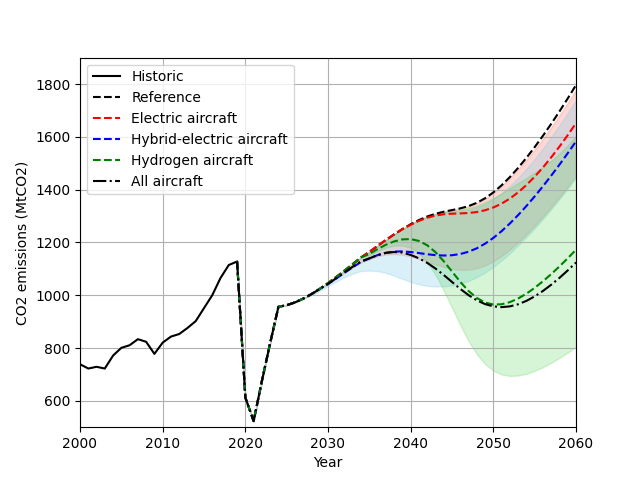

In [17]:
data_years_total = list(range(1940, 2101))

fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_reference[0:42],
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electric[0:42],
    color="red",
    label="Electric aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_electric_low[0:42],
    mea_data_electric_high[0:42],
    color="salmon",
    alpha=0.3,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hybridelectric[0:42],
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_hybridelectric_low[0:42],
    mea_data_hybridelectric_high[0:42],
    color="skyblue",
    alpha=0.3,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hydrogen[0:42],
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_hydrogen_low[0:42],
    mea_data_hydrogen_high[0:42],
    color="limegreen",
    alpha=0.2,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_mix[0:42],
    color="black",
    label="All aircraft",
    linestyle="-.",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(500, 1900)
plt.legend()
plt.show()

## Sensitivity to electricity emission factor

In [18]:
mea_data_electricity_df = read_csv("data/mea_data_electricity.csv", delimiter=";")
mea_data_electricity = mea_data_electricity_df.values
mea_data_electricity_electric = mea_data_electricity[:, 1]
mea_data_electricity_hybridelectric = mea_data_electricity[:, 2]
mea_data_electricity_hydrogen = mea_data_electricity[:, 3]
mea_data_electricity_mix = mea_data_electricity[:, 4]

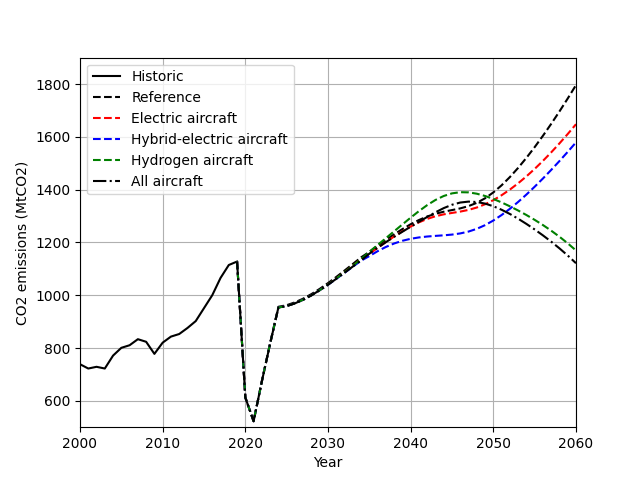

In [19]:
fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_reference[0:42],
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_electric,
    color="red",
    label="Electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_hybridelectric,
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_hydrogen,
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_mix,
    color="black",
    label="All aircraft",
    linestyle="-.",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(500, 1900)
plt.legend()
plt.show()

## Sensitivity to ReFuelEU

In [20]:
mea_data_refueleu_df = read_csv("data/mea_data_refueleu.csv", delimiter=";")
mea_data_refueleu = mea_data_refueleu_df.values
mea_data_refueleu_reference = mea_data_refueleu[:, 1]
mea_data_refueleu_electric = mea_data_refueleu[:, 2]
mea_data_refueleu_hybridelectric = mea_data_refueleu[:, 3]
mea_data_refueleu_hydrogen = mea_data_refueleu[:, 4]
mea_data_refueleu_mix = mea_data_refueleu[:, 5]

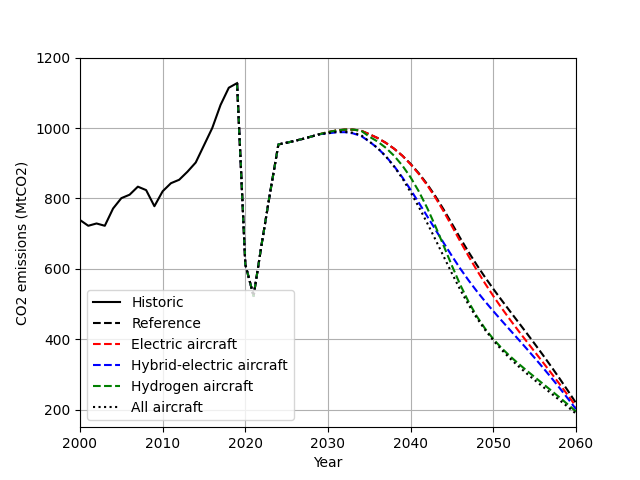

In [21]:
fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_reference,
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_electric,
    color="red",
    label="Electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hybridelectric,
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hydrogen,
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_mix,
    color="black",
    label="All aircraft",
    linestyle=":",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(150, 1200)
plt.legend()
plt.show()